<a href="https://colab.research.google.com/github/Hotckiss/DUL/blob/hw2/hw2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ModuleList
from torch.distributions import Normal, MultivariateNormal, Uniform
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [0]:
def sample_data():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
X, y  = sample_data()

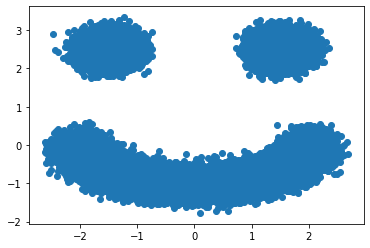

In [229]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [0]:
def loss_(y):
    return -torch.mean(torch.log(y)) / 2

In [0]:
def plot_loss(loss_train, loss_val):
  plt.plot(loss_train, label = "train")
  plt.plot(loss_val, label = "validate")
  plt.legend()
  plt.show()

In [0]:
def gen_sample(pos, pi, mu, sigma):
    uni, sum_pi = np.random.uniform(), 0

    for k in range(pi.shape[1]):
      sum_pi += pi.data[pos, k]
      if uni < sum_pi:
        return np.random.normal(mu.data[pos, k], np.sqrt(sigma.data[pos, k]))

In [0]:
def gen_samples(pi, sigma, mu, samples):
  res = Variable(torch.zeros(pi.shape[0], samples, 1))
  for i in range(pi.shape[0]):
    for j in range(samples):
      res[i, j, 0] = gen_sample(i, pi, mu, sigma)
  return res

In [0]:
class MyLayer(nn.Module):
    def __init__(self, k=8):
        super(MyLayer, self).__init__()
        self.k = k
        self.pi_ = nn.Parameter(torch.randn(k))
        self.softmax = nn.Softmax(dim=-1)
        self.mu_ = nn.Parameter(torch.randn(k))
        self.sigma_ = nn.Parameter(torch.randn(k))

    def params(self, x):
        x1, x2 = x[:, :1], x[:, 1:]
        pi, mu, sigma = self.softmax(self.pi_.repeat(x1.shape[0], 1)), self.mu_.repeat(x1.shape[0], 1), torch.abs(self.sigma_.repeat(x1.shape[0], 1))
        return pi, mu, sigma

    def forward(self, x):
      x1, x2 = x[:, :1], x[:, 1:]
      pi, mu, sigma =  self.params(x)      
      p = torch.zeros(x1.shape[0], 1)

      for i in range(self.k):
          p += pi[:,i:i+1] * (Normal(mu[:,i:i+1].float(), (sigma[:,i:i+1]).float()).log_prob(x1).exp())
        
      return p

In [0]:
class MyLayer2(nn.Module):
    def __init__(self, k=8):
        super(MyLayer2, self).__init__()
        self.k = k
        self.hidden = nn.Sequential(nn.Linear(1, 128), nn.ReLU())
        self.pi_ = nn.Sequential(nn.Linear(128, self.k), nn.Softmax(dim=-1))
        self.mu_ = nn.Linear(128, self.k)
        self.sigma_ = nn.Linear(128, self.k)

    def params2(self, x):
        h = self.hidden(x)
        return self.pi_(h), self.mu_(h), torch.abs(self.sigma_(h))

    def params(self, x):
        return self.params2(x[:, :1])

    def forward(self, x):
      x1, x2 = x[:, :1], x[:, 1:]
      pi, mu, sigma = self.params(x)      
      p = torch.zeros(x1.shape[0], 1)

      for i in range(self.k):
          p += pi[:,i:i+1] * (Normal(mu[:,i:i+1].float(), (sigma[:,i:i+1]).float()).log_prob(x2).exp())
        
      return p

In [0]:
class MyFlow(nn.Module):
    def __init__(self, k=8):
        super(MyFlow, self).__init__()
        self.k = k
        self.l1 = MyLayer(k)
        self.l2 = MyLayer2(k)
    
    def params1(self, x):
        return self.l1.params(x)

    def params2(self, x):
        return self.l2.params(x)
    
    def forward(self, x):
      return self.l1.forward(x) * self.l2.forward(x)

    def __call__(self, x):
        return self.forward(x)

In [0]:
X, y = sample_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125)
X_train, X_test, X_val, y_train, y_test, y_val = torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(X_val), torch.FloatTensor(y_train), torch.FloatTensor(y_test), torch.FloatTensor(y_val)

In [0]:
model = MyFlow().float()
batch_size = 512
epochs_cnt = 16
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
def train():
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(X_val, batch_size=batch_size)
    loss_train, loss_val = [], []

    for epoch in range(epochs_cnt):
        loss_it = []
        
        model.train()
        for batch in train_loader:
            out = model(batch)
            loss = loss_(out)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_it.append(loss.detach().numpy())
        loss_train.append(np.mean(loss_it))
        
        model.eval()
        with torch.no_grad():
            loss_it = []
            for batch in val_loader:
                out = model(batch)
                loss = loss_(out)
                loss_it.append(loss.detach().numpy())
            loss_val.append(np.mean(loss_it))

        print("It: " + str(epoch) + " Train loss: " + str(loss_train[-1]) + " Val loss: " + str(loss_val[-1]))

    loss_values = []
    for batch in test_loader:
        out = model(batch)
        loss = loss_(out)
        loss_values.append(loss.item())

    print("Test loss: " + str(np.mean(np.array(loss_values))))
    return loss_train, loss_val

It: 0 Train loss: 2.049607 Val loss: 1.518184
It: 1 Train loss: 1.3798928 Val loss: 1.2986983
It: 2 Train loss: 1.2558421 Val loss: 1.212485
It: 3 Train loss: 1.176619 Val loss: 1.1383252
It: 4 Train loss: 1.1050817 Val loss: 1.0601196
It: 5 Train loss: 1.0298703 Val loss: 0.999224
It: 6 Train loss: 0.98590666 Val loss: 0.97127277
It: 7 Train loss: 0.94543034 Val loss: 0.920543
It: 8 Train loss: 0.8903365 Val loss: 0.8459207
It: 9 Train loss: 0.79984355 Val loss: 0.7700124
It: 10 Train loss: 0.76265836 Val loss: 0.7459782
It: 11 Train loss: 0.74140614 Val loss: 0.7293975
It: 12 Train loss: 0.7251609 Val loss: 0.7169872
It: 13 Train loss: 0.71305656 Val loss: 0.7054237
It: 14 Train loss: 0.7061079 Val loss: 0.6995374
It: 15 Train loss: 0.6975721 Val loss: 0.6936276
Test loss: 0.691765832901001


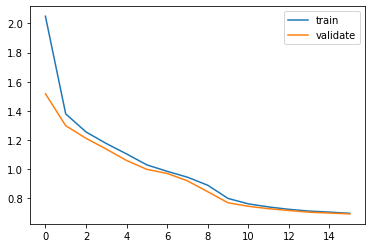

In [240]:
loss_train, loss_val = train()
plot_loss(loss_train, loss_val)

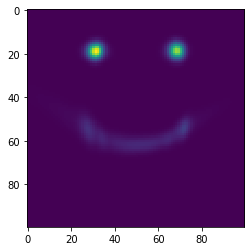

In [241]:
space = np.linspace(-4, 4, 100)
samples = torch.from_numpy(np.array(np.meshgrid(space, space)).T.reshape([-1, 2])).float()
pdf = model(samples).cpu().detach().numpy().reshape(100, 100)
plt.imshow(np.rot90(pdf, 1))

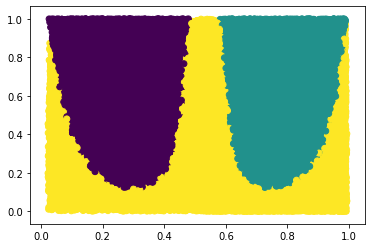

In [242]:
pi1, mu1, sigma1 = model.params1(X_train)
pi2, mu2, sigma2 = model.params2(X_train)
z1, z2 = torch.zeros(X_train[:, :1].shape[0], 1), torch.zeros(X_train[:, :1].shape[0], 1)
      
x1, x2 = X_train[:, :1], X_train[:, 1:]
      
for i in range(model.k):
    z1 += pi1[:,i:i+1] * (Normal(mu1[:,i:i+1].float(),(sigma1[:,i:i+1]).float()).cdf(x1))
    z2 += pi2[:,i:i+1] * (Normal(mu2[:,i:i+1].float(),(sigma2[:,i:i+1]).float()).cdf(x2))

plt.figure()
plt.scatter(z1[:, 0].detach().numpy(), z2[:, 0].detach().numpy(), c=y_train)
plt.show()

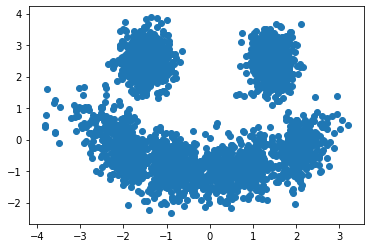

In [245]:
pi1, mu1, sigma1 = model.l1.softmax(model.l1.pi_.view(1,-1)), model.l1.mu_.view(1,-1), torch.abs(model.l1.sigma_).view(1,-1)
p1 = gen_samples(pi1, sigma1, mu1, samples=3000)
pi2, mu2, sigma2 = model.l2.params2(p1)
p2 = gen_samples(pi2[0], sigma2[0], mu2[0], samples=1)
plt.figure()
plt.scatter(p1, p2)
plt.show()

In [0]:
class RealNVP(nn.Module):
    def __init__(self, k=8):
        super(RealNVP, self).__init__()
        self.mask = nn.Parameter(torch.from_numpy(np.array([[0, 1], [1, 0]] * k).astype(np.float32)), requires_grad=False)

        layers1 = []
        for _ in range(k):
            layers1.append(nn.Sequential(nn.Linear(2, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 2), nn.Tanh()))

        layers2 = []
        for _ in range(k):
            layers2.append(nn.Sequential(nn.Linear(2, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 2)))
    
        self.t = ModuleList(layers1)
        self.s = ModuleList(layers2)

    def forward(self, x):
        det = x.new_zeros(x.shape[0])
        for i in range(len(self.t)):
            s = self.s[i](self.mask[i] * x) * (1 - self.mask[i])
            t = self.t[i](self.mask[i] * x) * (1 - self.mask[i])
            x = self.mask[i] * x + (1 - self.mask[i]) * (x * torch.exp(s) + t)
            det += s.sum(dim=1)
        return x, det

    def __call__(self, x):
        return self.forward(x)

In [0]:
dist = MultivariateNormal(torch.zeros(2), torch.eye(2))

In [0]:
def rloss(x):
    return -((dist.log_prob(x[0]) + x[1]) / 2).mean()

In [0]:
model = RealNVP().float()
batch_size = 512
epochs_cnt = 16
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
def train2():
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(X_val, batch_size=batch_size)
    loss_train, loss_val = [], []

    for epoch in range(epochs_cnt):
        loss_it = []
        
        model.train()
        for batch in train_loader:
            out = model(batch)
            loss = rloss(out)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_it.append(loss.detach().numpy())
        loss_train.append(np.mean(loss_it))
        
        model.eval()
        with torch.no_grad():
            loss_it = []
            for batch in val_loader:
                out = model(batch)
                loss = rloss(out)
                loss_it.append(loss.detach().numpy())
            loss_val.append(np.mean(loss_it))

        print("It: " + str(epoch) + " Train loss: " + str(loss_train[-1]) + " Val loss: " + str(loss_val[-1]))

    loss_values = []
    for batch in test_loader:
        out = model(batch)
        loss = rloss(out)
        loss_values.append(loss.item())

    print("Test loss: " + str(np.mean(np.array(loss_values))))
    return loss_train, loss_val

It: 0 Train loss: 1.2705234 Val loss: 1.0390003
It: 1 Train loss: 0.85599875 Val loss: 0.83400595
It: 2 Train loss: 0.7999021 Val loss: 0.820975
It: 3 Train loss: 0.76666844 Val loss: 0.7823617
It: 4 Train loss: 0.75489634 Val loss: 0.7854743
It: 5 Train loss: 0.7489826 Val loss: 0.73722756
It: 6 Train loss: 0.7434628 Val loss: 0.7418295
It: 7 Train loss: 0.73866904 Val loss: 0.76057875
It: 8 Train loss: 0.73469734 Val loss: 0.7333526
It: 9 Train loss: 0.7319838 Val loss: 0.72878623
It: 10 Train loss: 0.7240729 Val loss: 0.71814156
It: 11 Train loss: 0.7225469 Val loss: 0.71424615
It: 12 Train loss: 0.7240841 Val loss: 0.73804843
It: 13 Train loss: 0.7203229 Val loss: 0.713148
It: 14 Train loss: 0.7223113 Val loss: 0.7174917
It: 15 Train loss: 0.715948 Val loss: 0.7235202
Test loss: 0.7251608431339264


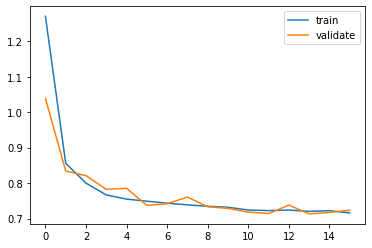

In [250]:
loss_train, loss_val = train2()
plot_loss(loss_train, loss_val)

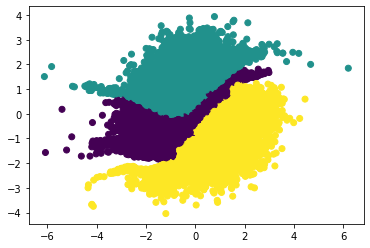

In [254]:
z, _ = model(X_train)
z1, z2 = z[:, 0], z[:, 1]
plt.scatter(z1.detach().numpy(), z2.detach().numpy(), c=y_train)
plt.show()

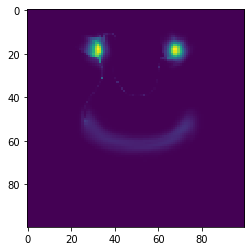

In [255]:
space = np.linspace(-4, 4, 100)
samples = torch.from_numpy(np.array(np.meshgrid(space, space)).T.reshape([-1, 2])).float()
with torch.no_grad():
    z, t = model(samples)
    z = (dist.log_prob(z) + t).exp()
    z = z.cpu().numpy()
    z = z.reshape(100, 100)
        
plt.imshow(np.rot90(z))
plt.show()

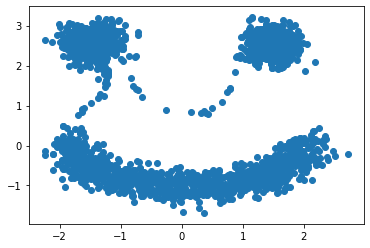

In [253]:
x = dist.sample((3000, 1))

for i in reversed(range(len(model.t))):
    x_masked = model.mask[i] * x
    s = model.s[i](x_masked) * (1 - model.mask[i])
    t = model.t[i](x_masked) * (1 - model.mask[i])
    x = (1 - model.mask[i]) * (x - t) * torch.exp(-s) + x_masked

x1, x2 = x[:, 0, 0], x[:, 0, 1]
plt.scatter(x1.detach().numpy(), x2.detach().numpy())
plt.show()